<a href="https://colab.research.google.com/github/eladprager/IDC-Reinforcement-Learning-Ass1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid-semester assignment - reinforcements learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Elad Prager 200865780

# Goodluck!

## Installs

In [ ]:
 !pip install gym
 !pip install pygame
 !apt-get install python-opengl -y
 !apt install xvfb -y
 !pip install pyvirtualdisplay
 !pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


## Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


 ## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()



if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1



"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
def show_video_middle_of_training():
  mp4list = glob.glob('video_middle_of_training/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env_middle_of_training(env):
  env = Monitor(env, './video_middle_of_training', force=True)
  return env

## MazeEnv
The cell below contains the configuration of the maze environment. No need to make changes here.

In [ ]:

class MazeEnv(gym.Env):
    metadata = {
        "render.modes": ["human", "rgb_array"],
    }

    ACTION = ["N", "S", "E", "W"]

    def __init__(self, maze_file=None, maze_size=None, mode=None, enable_render=True):
        self.visit_first = False
        self.visit_second = False

        self.viewer = None
        self.enable_render = enable_render

        if maze_file:
            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%s)" % maze_file,
                                        maze_file_path=maze_file,
                                        screen_size=(640, 640), 
                                        enable_render=enable_render)
        elif maze_size:
            if mode == "plus":
                has_loops = True
                num_portals = int(round(min(maze_size)/3))
            else:
                has_loops = False
                num_portals = 0

            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%d x %d)" % maze_size,
                                        maze_size=maze_size, screen_size=(640, 640),
                                        has_loops=has_loops, num_portals=num_portals,
                                        enable_render=enable_render)
        else:
            raise AttributeError("One must supply either a maze_file path (str) or the maze_size (tuple of length 2)")

        self.maze_size = self.maze_view.maze_size

        # forward or backward in each dimension
        self.action_space = spaces.Discrete(2*len(self.maze_size))

        # observation is the x, y coordinate of the grid
        low = np.zeros(len(self.maze_size), dtype=int)
        high =  np.array(self.maze_size, dtype=int) - np.ones(len(self.maze_size), dtype=int)
        self.observation_space = spaces.Box(low, high, dtype=np.int64)

        # initial condition
        self.state = None
        self.steps_beyond_done = None

        # Simulation related variables.
        self.seed()
        self.reset()

        # Just need to initialize the relevant attributes
        self.configure()

    def __del__(self):
        if self.enable_render is True:
            self.maze_view.quit_game()

    def configure(self, display=None):
        self.display = display

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
      # #stochastic transition model implementation: (we've decided to move that into the training functions)
      #   n = np.random.uniform(0, 1)
      #   if n < (4/30):
      #     action = self.action_space.sample()
      # ############################################
      
        if isinstance(action, int):

            self.maze_view.move_robot(self.ACTION[action])
        else:
            self.maze_view.move_robot(action)

        

        if np.array_equal(self.maze_view.robot, self.maze_view.goal):
            reward = 1
            done = True
        # (we've decided to remove these rewards since they didn't aid for convergence)
        # if np.array_equal(self.maze_view.robot, self.maze_view.first_goal) and not self.visit_first:
        #     reward = 0.001/(self.maze_size[0]*self.maze_size[1])
        #     done = False
        #     self.visit_first = True
        # if np.array_equal(self.maze_view.robot, self.maze_view.second_goal) and not self.visit_second:
        #     reward = 0.001/(self.maze_size[0]*self.maze_size[1])
        #     done = False
        #     self.visit_second = True
        else:
            # reward = -(math.sqrt(0.1/(self.maze_size[0]*self.maze_size[1])))
            # reward = -0.1/(math.sqrt(self.maze_size[0]*self.maze_size[1]))
            reward = -0.1/(self.maze_size[0]*self.maze_size[1])
            done = False

        self.state = self.maze_view.robot

        info = {}

        return self.state, reward, done, info

    def reset(self):
        self.maze_view.reset_robot()
        self.state = np.zeros(2)
        self.steps_beyond_done = None
        self.done = False
        return self.state

    def is_game_over(self):
        return self.maze_view.game_over

    def render(self, mode="human", close=False):
        if close:
            self.maze_view.quit_game()

        return self.maze_view.update(mode)



class MazeView2D:

    def __init__(self, maze_name="Maze2D", maze_file_path=None,
                 maze_size=(30, 30), screen_size=(600, 600),
                 has_loops=False, num_portals=0, enable_render=True):

        # PyGame configurations
        pygame.init()
        pygame.display.set_caption(maze_name)
        self.clock = pygame.time.Clock()
        self.__game_over = False
        self.__enable_render = enable_render

        # Load a maze
        if maze_file_path is None:
            self.__maze = Maze(maze_size=maze_size, has_loops=has_loops, num_portals=num_portals)
        else:
            if not os.path.exists(maze_file_path):
                dir_path = os.path.dirname(os.path.abspath(__file__))
                rel_path = os.path.join(dir_path, "maze_samples", maze_file_path)
                if os.path.exists(rel_path):
                    maze_file_path = rel_path
                else:
                    raise FileExistsError("Cannot find %s." % maze_file_path)
            self.__maze = Maze(maze_cells=Maze.load_maze(maze_file_path))

        self.maze_size = self.__maze.maze_size
        if self.__enable_render is True:
            # to show the right and bottom border
            self.screen = pygame.display.set_mode(screen_size)
            self.__screen_size = tuple(map(sum, zip(screen_size, (-1, -1))))

        # Set the starting point
        self.__entrance = np.zeros(2, dtype=int)

        # Set the Goal
        self.__goal = np.array(self.maze_size) - np.array((1, 1))
        self.__first_goal = np.array((1, 17))
        self.__second_goal = np.array((12, 28))

        # Create the Robot
        self.__robot = self.entrance

        if self.__enable_render is True:
            # Create a background
            self.background = pygame.Surface(self.screen.get_size()).convert()
            self.background.fill((255, 255, 255))

            # Create a layer for the maze
            self.maze_layer = pygame.Surface(self.screen.get_size()).convert_alpha()
            self.maze_layer.fill((0, 0, 0, 0,))

            # show the maze
            self.__draw_maze()

            # show the portals
            self.__draw_portals()

            # show the robot
            self.__draw_robot()

            # show the entrance
            self.__draw_entrance()

            # show the goal
            self.__draw_goal()

    def update(self, mode="human"):
        try:
            img_output = self.__view_update(mode)
            self.__controller_update()
        except Exception as e:
            self.__game_over = True
            self.quit_game()
            raise e
        else:
            return img_output

    def quit_game(self):
        try:
            self.__game_over = True
            if self.__enable_render is True:
                pygame.display.quit()
            pygame.QUIT
        except Exception:
            pass

    def move_robot(self, dir):
        if dir not in self.__maze.COMPASS.keys():
            raise ValueError("dir cannot be %s. The only valid dirs are %s."
                             % (str(dir), str(self.__maze.COMPASS.keys())))

        if self.__maze.is_open(self.__robot, dir):

            # update the drawing
            self.__draw_robot(transparency=0)

            # move the robot
            self.__robot += np.array(self.__maze.COMPASS[dir])
            # if it's in a portal afterward
            if self.maze.is_portal(self.robot):
                self.__robot = np.array(self.maze.get_portal(tuple(self.robot)).teleport(tuple(self.robot)))
            self.__draw_robot(transparency=255)

    def reset_robot(self):

        self.__draw_robot(transparency=0)
        self.__robot = np.zeros(2, dtype=int)
        self.__draw_robot(transparency=255)

    def __controller_update(self):
        if not self.__game_over:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.__game_over = True
                    self.quit_game()

    def __view_update(self, mode="human"):
        if not self.__game_over:
            # update the robot's position
            self.__draw_entrance()
            self.__draw_goal()
            self.__draw_portals()
            self.__draw_robot()


            # update the screen
            self.screen.blit(self.background, (0, 0))
            self.screen.blit(self.maze_layer,(0, 0))

            if mode == "human":
                pygame.display.flip()

            return np.flipud(np.rot90(pygame.surfarray.array3d(pygame.display.get_surface())))

    def __draw_maze(self):
        
        if self.__enable_render is False:
            return
        
        line_colour = (0, 0, 0, 255)

        # drawing the horizontal lines
        for y in range(self.maze.MAZE_H + 1):
            pygame.draw.line(self.maze_layer, line_colour, (0, y * self.CELL_H),
                             (self.SCREEN_W, y * self.CELL_H))

        # drawing the vertical lines
        for x in range(self.maze.MAZE_W + 1):
            pygame.draw.line(self.maze_layer, line_colour, (x * self.CELL_W, 0),
                             (x * self.CELL_W, self.SCREEN_H))

        # breaking the walls
        for x in range(len(self.maze.maze_cells)):
            for y in range (len(self.maze.maze_cells[x])):
                # check the which walls are open in each cell
                walls_status = self.maze.get_walls_status(self.maze.maze_cells[x, y])
                dirs = ""
                for dir, open in walls_status.items():
                    if open:
                        dirs += dir
                self.__cover_walls(x, y, dirs)

    def __cover_walls(self, x, y, dirs, colour=(0, 0, 255, 15)):

        if self.__enable_render is False:
            return
        
        dx = x * self.CELL_W
        dy = y * self.CELL_H

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        for dir in dirs:
            if dir == "S":
                line_head = (dx + 1, dy + self.CELL_H)
                line_tail = (dx + self.CELL_W - 1, dy + self.CELL_H)
            elif dir == "N":
                line_head = (dx + 1, dy)
                line_tail = (dx + self.CELL_W - 1, dy)
            elif dir == "W":
                line_head = (dx, dy + 1)
                line_tail = (dx, dy + self.CELL_H - 1)
            elif dir == "E":
                line_head = (dx + self.CELL_W, dy + 1)
                line_tail = (dx + self.CELL_W, dy + self.CELL_H - 1)
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            pygame.draw.line(self.maze_layer, colour, line_head, line_tail)

    def __draw_robot(self, colour=(0, 0, 150), transparency=255):

        if self.__enable_render is False:
            return
        
        x = int(self.__robot[0] * self.CELL_W + self.CELL_W * 0.5 + 0.5)
        y = int(self.__robot[1] * self.CELL_H + self.CELL_H * 0.5 + 0.5)
        r = int(min(self.CELL_W, self.CELL_H)/5 + 0.5)

        pygame.draw.circle(self.maze_layer, colour + (transparency,), (x, y), r)

    def __draw_entrance(self, colour=(0, 0, 150), transparency=235):

        self.__colour_cell(self.entrance, colour=colour, transparency=transparency)

    def __draw_goal(self, colour=(150, 0, 0), transparency=235):

        self.__colour_cell(self.goal, colour=colour, transparency=transparency)

    def __draw_portals(self, transparency=160):

        if self.__enable_render is False:
            return
        
        colour_range = np.linspace(0, 255, len(self.maze.portals), dtype=int)
        colour_i = 0
        for portal in self.maze.portals:
            colour = ((100 - colour_range[colour_i])% 255, colour_range[colour_i], 0)
            colour_i += 1
            for location in portal.locations:
                self.__colour_cell(location, colour=colour, transparency=transparency)

    def __colour_cell(self, cell, colour, transparency):

        if self.__enable_render is False:
            return

        if not (isinstance(cell, (list, tuple, np.ndarray)) and len(cell) == 2):
            raise TypeError("cell must a be a tuple, list, or numpy array of size 2")

        x = int(cell[0] * self.CELL_W + 0.5 + 1)
        y = int(cell[1] * self.CELL_H + 0.5 + 1)
        w = int(self.CELL_W + 0.5 - 1)
        h = int(self.CELL_H + 0.5 - 1)
        pygame.draw.rect(self.maze_layer, colour + (transparency,), (x, y, w, h))

    @property
    def maze(self):
        return self.__maze

    @property
    def robot(self):
        return self.__robot

    @property
    def entrance(self):
        return self.__entrance

    @property
    def goal(self):
        return self.__goal

    @property
    def first_goal(self):
        return self.__first_goal

    @property
    def second_goal(self):
        return self.__second_goal

    @property
    def game_over(self):
        return self.__game_over

    @property
    def SCREEN_SIZE(self):
        return tuple(self.__screen_size)

    @property
    def SCREEN_W(self):
        return int(self.SCREEN_SIZE[0])

    @property
    def SCREEN_H(self):
        return int(self.SCREEN_SIZE[1])

    @property
    def CELL_W(self):
        return float(self.SCREEN_W) / float(self.maze.MAZE_W)

    @property
    def CELL_H(self):
        return float(self.SCREEN_H) / float(self.maze.MAZE_H)

class Maze:

    COMPASS = {
        "N": (0, -1),
        "E": (1, 0),
        "S": (0, 1),
        "W": (-1, 0)
    }

    def __init__(self, maze_cells=None, maze_size=(10,10), has_loops=True, num_portals=0):

        # maze member variables
        self.maze_cells = maze_cells
        self.has_loops = has_loops
        self.__portals_dict = dict()
        self.__portals = []
        self.num_portals = num_portals

        # Use existing one if exists
        if self.maze_cells is not None:
            if isinstance(self.maze_cells, (np.ndarray, np.generic)) and len(self.maze_cells.shape) == 2:
                self.maze_size = tuple(maze_cells.shape)
            else:
                raise ValueError("maze_cells must be a 2D NumPy array.")
        # Otherwise, generate a random one
        else:
            raise ValueError("Please upload the maze you downloaded in the submission box!")
         

    def save_maze(self, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(os.path.dirname(file_path)):
            raise ValueError("Cannot find the directory for %s." % file_path)

        else:
            np.save(file_path, self.maze_cells, allow_pickle=False, fix_imports=True)

    @classmethod
    def load_maze(cls, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(file_path):
            raise ValueError("Cannot find %s." % file_path)

        else:
            return np.load(file_path, allow_pickle=False, fix_imports=True)

    def __break_random_walls(self, percent):
        # find some random cells to break
        num_cells = int(round(self.MAZE_H*self.MAZE_W*percent))
        cell_ids = random.sample(range(self.MAZE_W*self.MAZE_H), num_cells)

        # for each of those walls
        for cell_id in cell_ids:
            x = cell_id % self.MAZE_H
            y = int(cell_id/self.MAZE_H)

            # randomize the compass order
            dirs = random.sample(list(self.COMPASS.keys()), len(self.COMPASS))
            for dir in dirs:
                # break the wall if it's not already open
                if self.is_breakable((x, y), dir):
                    self.maze_cells[x, y] = self.__break_walls(self.maze_cells[x, y], dir)
                    break

    def __set_random_portals(self, num_portal_sets, set_size=2):
        # find some random cells to break
        num_portal_sets = int(num_portal_sets)
        set_size = int(set_size)

        # limit the maximum number of portal sets to the number of cells available.
        max_portal_sets = int(self.MAZE_W * self.MAZE_H / set_size)
        num_portal_sets = min(max_portal_sets, num_portal_sets)

        # the first and last cells are reserved
        cell_ids = random.sample(range(1, self.MAZE_W * self.MAZE_H - 1), num_portal_sets*set_size)

        for i in range(num_portal_sets):
            # sample the set_size number of sell
            portal_cell_ids = random.sample(cell_ids, set_size)
            portal_locations = []
            for portal_cell_id in portal_cell_ids:
                # remove the cell from the set of potential cell_ids
                cell_ids.pop(cell_ids.index(portal_cell_id))
                # convert portal ids to location
                x = portal_cell_id % self.MAZE_H
                y = int(portal_cell_id / self.MAZE_H)
                portal_locations.append((x,y))
            # append the new portal to the maze
            portal = Portal(*portal_locations)
            self.__portals.append(portal)

            # create a dictionary of portals
            for portal_location in portal_locations:
                self.__portals_dict[portal_location] = portal

    def is_open(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        # if cell is still within bounds after the move
        if self.is_within_bound(x1, y1):
            # check if the wall is opened
            this_wall = bool(self.get_walls_status(self.maze_cells[cell_id[0], cell_id[1]])[dir])
            other_wall = bool(self.get_walls_status(self.maze_cells[x1, y1])[self.__get_opposite_wall(dir)])
            return this_wall or other_wall
        return False

    def is_breakable(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        return not self.is_open(cell_id, dir) and self.is_within_bound(x1, y1)

    def is_within_bound(self, x, y):
        # true if cell is still within bounds after the move
        return 0 <= x < self.MAZE_W and 0 <= y < self.MAZE_H

    def is_portal(self, cell):
        return tuple(cell) in self.__portals_dict

    @property
    def portals(self):
        return tuple(self.__portals)

    def get_portal(self, cell):
        if cell in self.__portals_dict:
            return self.__portals_dict[cell]
        return None

    @property
    def MAZE_W(self):
        return int(self.maze_size[0])

    @property
    def MAZE_H(self):
        return int(self.maze_size[1])

    @classmethod
    def get_walls_status(cls, cell):
        walls = {
            "N" : (cell & 0x1) >> 0,
            "E" : (cell & 0x2) >> 1,
            "S" : (cell & 0x4) >> 2,
            "W" : (cell & 0x8) >> 3,
        }
        return walls

    @classmethod
    def all_walls_intact(cls, cell):
        return cell & 0xF == 0

    @classmethod
    def num_walls_broken(cls, cell):
        walls = cls.get_walls_status(cell)
        num_broken = 0
        for wall_broken in walls.values():
            num_broken += wall_broken
        return num_broken

    @classmethod
    def __break_walls(cls, cell, dirs):
        if "N" in dirs:
            cell |= 0x1
        if "E" in dirs:
            cell |= 0x2
        if "S" in dirs:
            cell |= 0x4
        if "W" in dirs:
            cell |= 0x8
        return cell

    @classmethod
    def __get_opposite_wall(cls, dirs):

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        opposite_dirs = ""

        for dir in dirs:
            if dir == "N":
                opposite_dir = "S"
            elif dir == "S":
                opposite_dir = "N"
            elif dir == "E":
                opposite_dir = "W"
            elif dir == "W":
                opposite_dir = "E"
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            opposite_dirs += opposite_dir

        return opposite_dirs
        
class MazeEnvSample15x15(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample15x15, self).__init__(maze_file="/content/maze2d_15x15.npy", enable_render=enable_render)


class MazeEnvSample30x30(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample30x30, self).__init__(maze_file="/content/maze2d_30x30.npy", enable_render=enable_render)

### Upload the maze files
Upload the maze files you downloaded in the submission box

In [ ]:
from google.colab import files
print('Please upload the maze2d_15x15 file')
maze2d_15x15 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_15x15)[0], length=len(list(maze2d_15x15)[0])))

print('\nPlease upload the maze2d_30x30 file')
maze2d_30x30 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_30x30)[0], length=len(list(maze2d_30x30)[0])))

Please upload the maze2d_15x15 file


Saving maze2d_15x15.npy to maze2d_15x15 (5).npy
User uploaded file "maze2d_15x15.npy" with length 16 bytes

Please upload the maze2d_30x30 file


Saving maze2d_30x30.npy to maze2d_30x30 (5).npy
User uploaded file "maze2d_30x30.npy" with length 16 bytes


## Environment check
Here you can check if the environment of the maze is working properly.<br> **If the first time you run the cell an error appears Try to run the cell again.**

---

### Environment 15X15

action: 3, observation: [0 0],  reward: -0.00044444444444444447, done: False


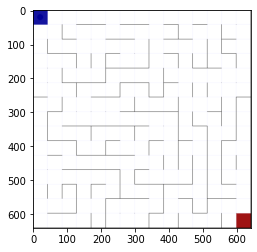

In [ ]:
env = MazeEnvSample15x15() 
env.reset()
plt.imshow(env.render('rgb_array'))
state_size = env.observation_space
a = env.action_space
state = env.reset()
env.render()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
env.render()
print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')


### Environment 30X30

iteration: 10, action: 2,  observation: [1 0], reward: -0.00011111111111111112, done: False


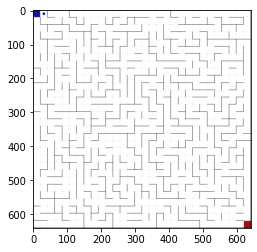

In [ ]:
env = MazeEnvSample30x30() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
iter = 0
print(done)
action = 1
while (iter < 10):#not done:
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

### Play video

In [ ]:
env.close()
show_video()

###Monte Carlo for 15x15

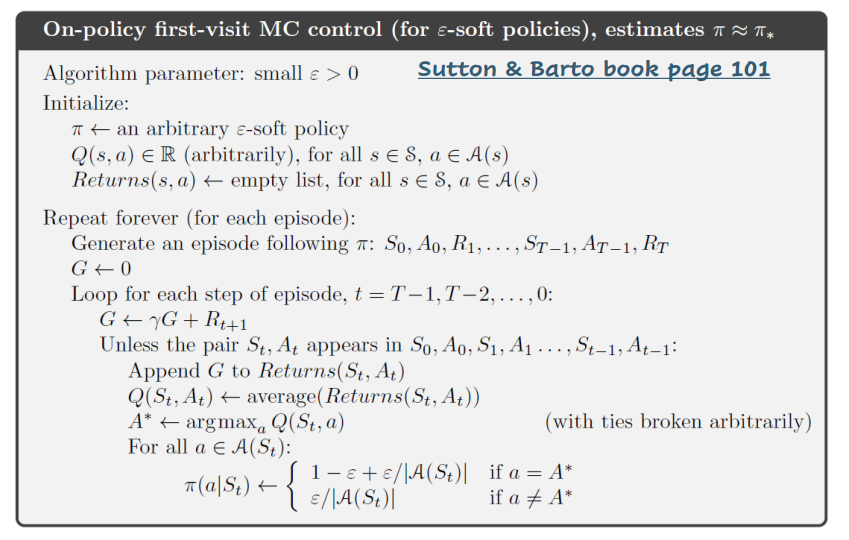

In [ ]:
# Initial Hyperparameters
EPOCHS = 1200
GAMMA = 0.95                  # discount rate
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

epsilon = 1.0               # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
random_init = 0            #prob to start from any state
max_steps = 15000

env = MazeEnvSample15x15()

def epsilon_greedy_action_selection(epsilon, Q, state):
    random_number = np.random.random()
    
    # EXPLOITATION
    if random_number < epsilon:
        state_row = Q[state,:]
        action = np.argmax(state_row)
    
    # EXPLORATION
    else:
        action = env.action_space.sample()

    return int(action)

def reduce_epsilon(epsilon, epoch, min_epsilon, decay_rate):   
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

#Function for Random Policy
def create_random_policy(env, action_size, state_size):
# we will build a random policy dictionary where the states are the keys
# each key will have a dictionary of probability per action 

  policy = {}
  for key in range(state_size):
      p = {} #probability dict
      for action in range(action_size):
            p[action] = 1 / action_size  #start with uniform distribution 
      policy[key] = p
  return policy

In [ ]:
#Function to play episode
def play_game(env, policy, episode, display=False, is_stochastic=False):
    
    #initialization
    env.reset()
    states = []
    actions = []
    rewards = []
    done = False
    
    #print("maze_view.robot", env.maze_view.robot)
    #print("state", env.state)
    steps = 0
    if np.random.uniform(0, 1) < random_init:
      state = env.observation_space.sample()
    else:
      state = env.state

    #print(f'Initial state is {state}')
    while not done and steps < max_steps:
          s = int(state[0]) * env.maze_size[0] + int(state[1])

          states.append(s)
          #Use stochastic policy for exploration 
          n = np.random.uniform(0, sum(policy[s].values()))
          top_range = 0
          for prob in policy[s].items():
            top_range += prob[1]
            if n < top_range:
              action = prob[0]
              break 
          
          #Use stochastic transition model 
          if is_stochastic:
            n = np.random.uniform(0, 1)
            if n < (4/30):
              action = env.action_space.sample()

          #action = policy[s]
          actions.append(action)
          #print(action)
          state, reward, done, info = env.step(action)
          rewards.append(reward)
          steps +=1
          
          if display:
            #For Debug 
            print(f'iteration: {steps}, action: {action},  observation: {state}, reward: {reward}, done: {done}')

    return states, actions, rewards, steps

In [ ]:
def train(epoch, discount, min_eps, decay, is_tuned, is_stochastic):
  EPOCHS = epoch
  GAMMA = discount
  min_epsilon = min_eps
  decay_rate = decay
  
  env = MazeEnvSample15x15()

  action_size = 4
  state_size = env.maze_size[0]*env.maze_size[1]
  Q = np.zeros([state_size, action_size])

  epsilon = 1

  rewards_list = []
  G_list = []
  steps_list = []
  moving_avg_steps = []
  returns = {}

  # initialize a random policy (deterministic)
  policy = create_random_policy(env,action_size, state_size)  # Create an empty dictionary to store state action values    

  # initialize Q(s,a) and returns
  #Q = create_state_action_dictionary(env, policy) 
  # Q = np.zeros([state_size, action_size])
  
  # repeat until convergence
  for episode in range(EPOCHS):
      if episode == (EPOCHS - 1) and is_tuned:
        env = wrap_env(env)
      if episode == (EPOCHS/2) and is_tuned and is_stochastic:
        env = wrap_env_middle_of_training(env)

      total_rewards = 0

      #generate an episode following a policy 
      states, actions, rewards, steps = play_game(env, policy, episode, is_stochastic=False )

      # create a list of only state-action pairs for lookup
      states_actions = list(zip(states, actions))

      G = 0

      #Loop for each state of episode
      for t in reversed(range(0, len(states))):
        # retrieve current s, a, r tuple
        s_t = states[t]
        a_t = actions[t]
        
        total_rewards = total_rewards + rewards[t]
        # update G
        G = rewards[t] + GAMMA * G

        state_action = (s_t, a_t)

        # check if we have already seen the pair (s, a) ("first-visit")
        if  state_action[0] not in states_actions[:t]:
          if returns.get(state_action):
            returns[state_action].append(G)
          else:
            returns[state_action] = [G]  

          Q[s_t][a_t] = sum(returns[state_action]) / len(returns[state_action]) # Average reward across episodes
          
          # Action row for a particular state
          state_row = Q[s_t,:]
          #print(f'state_row: {state_row}')
          # Finding the action with maximum value
          A_max = np.argmax(state_row)
          #print(A_max)
          #if A_max > 1:
          #  print('SHIAAAaaaaaa')


          # Update action probability for s_t in policy with epsilon greedy selection 
          
          A_s = abs(sum(policy[s_t].values()))
          for a in policy[s_t].items(): 
            #print(f'policy of state {s_t} at time{t}: {policy[s_t].values()}')
            #print(abs(sum(policy[s_t].values())))
            #print(f'A_max: {A_max}')
            if a[0] == A_max:
              policy[s_t][a[0]] = 1 - epsilon + (epsilon / A_s)
            else:
              policy[s_t][a[0]] = (epsilon / A_s)
          
      episode += 1

      epsilon = reduce_epsilon(epsilon,episode, min_epsilon, decay_rate) 
      steps_list.append(steps)
      rewards_list.append(total_rewards)
      G_list.append(G)
                
      if episode % 100 == 0:
        current_moving_avg_steps = sum(steps_list[-100:])/100
        moving_avg_steps.append(current_moving_avg_steps)
        print(f'episode: {episode}, total_rewards: {round(total_rewards, 4)}, total_current_steps: {steps}, moving_average_steps: {current_moving_avg_steps}')

      if episode == (EPOCHS) and is_tuned:
        env.close()
      if episode == (EPOCHS/2) and is_tuned and is_stochastic:
        env.close()

  return rewards_list, steps_list

In [ ]:
# Hyperparameters Tuning 
epoch_list = [1000, 1250, 1500, 1750, 2000]
gamma_list = [0.9, 0.925, 0.95, 0.975]
min_epsilon_list = [0.01, 0.03, 0.05, 0.07]
decay_rate_list = [0.001, 0.0025, 0.005, 0.0075]

print(f'\n########## hypter-tuning discount rate: ##########\n')
for discount in gamma_list:  
  print(f'discount rate is: {discount}')
  rewards, steps = train(EPOCHS, discount, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning minimum epsilon: ##########\n')
for min_eps in min_epsilon_list:
  print(f'minimum epsilon is: {min_eps}')
  rewards, steps = train(EPOCHS, GAMMA, min_eps, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning epsilon decay rate: ##########\n')
for decay in decay_rate_list:
  print(f'decay rate is: {decay}')
  rewards, steps = train(EPOCHS, GAMMA, min_epsilon, decay, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning number of epochs: ##########\n')
for epoch in epoch_list:
  print(f'number of epochs is: {epoch}')
  rewards, steps = train(epoch, GAMMA, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')


########## hypter-tuning discount rate: ##########

discount rate is: 0.9
episode: 100, total_rewards: 0.9231, total_current_steps: 174, moving_average_steps: 1023.18
episode: 200, total_rewards: 0.9662, total_current_steps: 77, moving_average_steps: 148.13
episode: 300, total_rewards: 0.9644, total_current_steps: 81, moving_average_steps: 83.19
episode: 400, total_rewards: 0.984, total_current_steps: 37, moving_average_steps: 54.37
episode: 500, total_rewards: 0.9796, total_current_steps: 47, moving_average_steps: 43.33
episode: 600, total_rewards: 0.9849, total_current_steps: 35, moving_average_steps: 40.37
episode: 700, total_rewards: 0.984, total_current_steps: 37, moving_average_steps: 33.55
episode: 800, total_rewards: 0.9871, total_current_steps: 30, moving_average_steps: 31.66
episode: 900, total_rewards: 0.9871, total_current_steps: 30, moving_average_steps: 31.99
episode: 1000, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 30.9
episode: 1100, total_rew

In [ ]:
# Convergence after Hyperparameters Tuning
EPOCHS = 1000
GAMMA = 0.9                   # Discount rate
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

rewards, steps = train(EPOCHS, GAMMA, min_epsilon, decay_rate, True, True)

episode: 100, total_rewards: 0.9324, total_current_steps: 153, moving_average_steps: 1052.91
episode: 200, total_rewards: 0.9431, total_current_steps: 129, moving_average_steps: 155.65
episode: 300, total_rewards: 0.9613, total_current_steps: 88, moving_average_steps: 79.84
episode: 400, total_rewards: 0.9738, total_current_steps: 60, moving_average_steps: 57.83
episode: 500, total_rewards: 0.9827, total_current_steps: 40, moving_average_steps: 56.94
episode: 600, total_rewards: 0.9844, total_current_steps: 36, moving_average_steps: 47.0
episode: 700, total_rewards: 0.984, total_current_steps: 37, moving_average_steps: 36.57
episode: 800, total_rewards: 0.9867, total_current_steps: 31, moving_average_steps: 33.47
episode: 900, total_rewards: 0.9862, total_current_steps: 32, moving_average_steps: 32.44
episode: 1000, total_rewards: 0.9867, total_current_steps: 31, moving_average_steps: 30.46


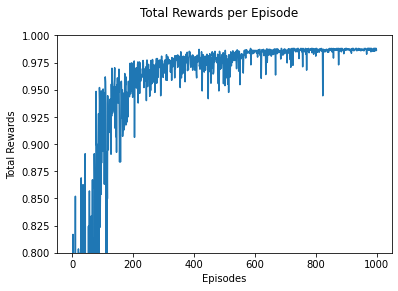

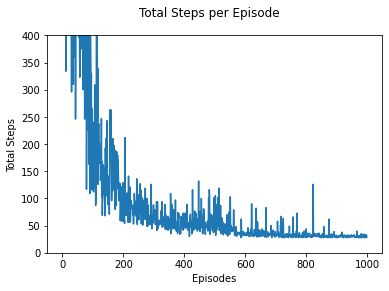

In [ ]:
# Convergence Graphs
plt.suptitle("Total Rewards per Episode")
plt.plot(rewards)
plt.ylabel('Total Rewards')
plt.xlabel("Episodes")
plt.ylim([0.8, 1])
plt.show()

plt.suptitle("Total Steps per Episode")
plt.plot(steps)
plt.ylabel('Total Steps')
plt.xlabel("Episodes")
plt.ylim([0, 400])
plt.show()

In [ ]:
# Stochastic Policy - Middle Episode
show_video_middle_of_training()

In [ ]:
# Stochastic Policy - Final Episode
show_video()

In [ ]:
# Convergence if we had a determenistic policy
EPOCHS = 2000
GAMMA = 0.9                   # discount rate
min_epsilon = 0.00            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

rewards, steps = train(EPOCHS, GAMMA, min_epsilon, decay_rate, True, False)

episode: 100, total_rewards: 0.7991, total_current_steps: 453, moving_average_steps: 1108.75
episode: 200, total_rewards: 0.9547, total_current_steps: 103, moving_average_steps: 157.16
episode: 300, total_rewards: 0.9698, total_current_steps: 69, moving_average_steps: 79.34
episode: 400, total_rewards: 0.9742, total_current_steps: 59, moving_average_steps: 60.63
episode: 500, total_rewards: 0.9804, total_current_steps: 45, moving_average_steps: 52.88
episode: 600, total_rewards: 0.9787, total_current_steps: 49, moving_average_steps: 49.75
episode: 700, total_rewards: 0.9729, total_current_steps: 62, moving_average_steps: 50.0
episode: 800, total_rewards: 0.9787, total_current_steps: 49, moving_average_steps: 56.08
episode: 900, total_rewards: 0.9876, total_current_steps: 29, moving_average_steps: 44.79
episode: 1000, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 30.26
episode: 1100, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 29.51
episod

In [ ]:
# Determenistic Policy - Best Policy in 28 steps
show_video()

###Q-Learning for 15x15

In [ ]:
# Initial Hyperparameters
EPOCHS =1200
ALPHA = 0.8                   # Learning rate
GAMMA = 0.95                  # Discount rate
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start

env = MazeEnvSample15x15()

def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    random_number = np.random.random()
    
    # EXPLOITATION
    if random_number > epsilon:
        state_row = q_table[discrete_state,:]
        action = np.argmax(state_row)
    
    # EXPLORATION
    else:
        action = env.action_space.sample()
    return action

def compute_next_q_value(old_q_value, reward, next_optimal_q_value, ALPHA, GAMMA): 
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

def reduce_epsilon(epsilon,epoch, min_epsilon, decay_rate):   
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

In [ ]:
def train(epoch, lr, discount, min_eps, decay, is_tuned, is_stochastic):
  EPOCHS = epoch
  ALPHA = lr
  GAMMA = discount
  min_epsilon = min_eps
  decay_rate = decay
  
  env = MazeEnvSample15x15()

  action_size = 4
  state_size = 15*15
  q_table = np.zeros([state_size, action_size])
  
  epsilon = 1

  rewards = []
  steps = []
  moving_avg_steps = []

  for episode in range(EPOCHS):
      if episode == (EPOCHS - 1) and is_tuned:
        env = wrap_env(env)
      if episode == (EPOCHS/2) and is_tuned and is_stochastic:
        env = wrap_env_middle_of_training(env)

      state = env.reset()
      state = int(state[0]) * 15 + int(state[1])

      done = False
      total_rewards = 0
      total_steps = 0

      while not done:
          action = epsilon_greedy_action_selection(epsilon,q_table, state)
          a = env.ACTION[action]

          if is_stochastic:
            n = np.random.uniform(0, 1)
            if n < (4/30):
              a = env.action_space.sample()

          new_state, reward, done, info = env.step(a)
          new_state = int(new_state[0]) * 15 + int(new_state[1])
          old_q_value =  q_table[state,action]  
          next_optimal_q_value = np.max(q_table[new_state, :])  
          next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value, ALPHA, GAMMA)   
          q_table[state,action] = next_q
          total_rewards = total_rewards + reward
          state = new_state
          total_steps += 1
      
      episode += 1

      epsilon = reduce_epsilon(epsilon,episode, min_epsilon, decay_rate) 
      rewards.append(total_rewards)
      steps.append(total_steps)
                
      if episode % 100 == 0:
        current_moving_avg_steps = sum(steps[-100:])/100
        moving_avg_steps.append(current_moving_avg_steps)
        print(f'episode: {episode}, total_rewards: {round(total_rewards, 4)}, total_current_steps: {total_steps}, moving_average_steps: {current_moving_avg_steps}')

      if episode == (EPOCHS) and is_tuned:
        env.close()
      if episode == (EPOCHS/2) and is_tuned and is_stochastic:
        env.close()
  return rewards, steps

In [ ]:
# Hyperparameters Tuning 
epoch_list = [1000, 1250, 1500, 1750, 2000]
alpha_list = [0.6, 0.7, 0.8, 0.9]
gamma_list = [0.9, 0.925, 0.95, 0.975]
min_epsilon_list = [0.01, 0.03, 0.05, 0.07]
decay_rate_list = [0.001, 0.005, 0.0001, 0.0005]

lr_dict = {}
print(f'\n########## hypter-tuning learning rate: ##########\n')
for lr in alpha_list:
  print(f'learning rate is: {lr}')
  rewards, steps = train(EPOCHS, lr, GAMMA, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning discount rate: ##########\n')
for discount in gamma_list:  
  print(f'discount rate is: {discount}')
  rewards, steps = train(EPOCHS, ALPHA, discount, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning minimum epsilon: ##########\n')
for min_eps in min_epsilon_list:
  print(f'minimum epsilon is: {min_eps}')
  rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_eps, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning epsilon decay rate: ##########\n')
for decay in decay_rate_list:
  print(f'decay rate is: {decay}')
  rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_epsilon, decay, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning number of epochs: ##########\n')
for epoch in epoch_list:
  print(f'number of epochs is: {epoch}')
  rewards, steps = train(epoch, ALPHA, GAMMA, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')
    


########## hypter-tuning learning rate: ##########

learning rate is: 0.6
episode: 100, total_rewards: 0.9676, total_current_steps: 74, moving_average_steps: 810.75
episode: 200, total_rewards: 0.9764, total_current_steps: 54, moving_average_steps: 77.06
episode: 300, total_rewards: 0.9831, total_current_steps: 39, moving_average_steps: 55.0
episode: 400, total_rewards: 0.9796, total_current_steps: 47, moving_average_steps: 43.88
episode: 500, total_rewards: 0.9853, total_current_steps: 34, moving_average_steps: 39.59
episode: 600, total_rewards: 0.9853, total_current_steps: 34, moving_average_steps: 37.92
episode: 700, total_rewards: 0.9871, total_current_steps: 30, moving_average_steps: 35.46
episode: 800, total_rewards: 0.9871, total_current_steps: 30, moving_average_steps: 37.42
episode: 900, total_rewards: 0.984, total_current_steps: 37, moving_average_steps: 35.93
episode: 1000, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 34.76
episode: 1100, total_rewar

In [ ]:
# Convergence after Hyperparameters Tuning
EPOCHS = 800
ALPHA = 0.6                   # Learning rate
GAMMA = 0.9                   # Discount rate
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_epsilon, decay_rate, True, True)

episode: 100, total_rewards: 0.9684, total_current_steps: 72, moving_average_steps: 823.67
episode: 200, total_rewards: 0.9773, total_current_steps: 52, moving_average_steps: 79.14
episode: 300, total_rewards: 0.9804, total_current_steps: 45, moving_average_steps: 55.08
episode: 400, total_rewards: 0.9831, total_current_steps: 39, moving_average_steps: 43.0
episode: 500, total_rewards: 0.9822, total_current_steps: 41, moving_average_steps: 41.48
episode: 600, total_rewards: 0.9858, total_current_steps: 33, moving_average_steps: 39.5
episode: 700, total_rewards: 0.9853, total_current_steps: 34, moving_average_steps: 39.57
episode: 800, total_rewards: 0.9853, total_current_steps: 34, moving_average_steps: 37.67


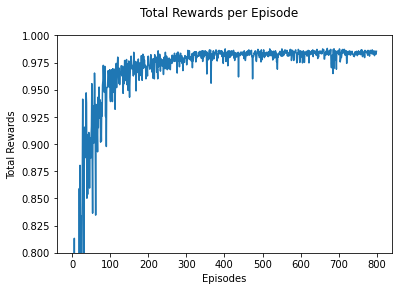

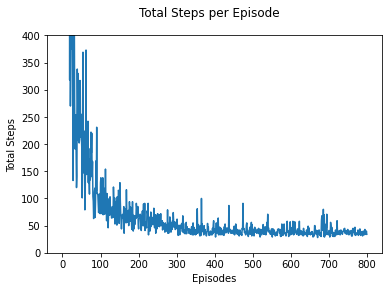

In [ ]:
# Convergence Graphs
plt.suptitle("Total Rewards per Episode")
plt.plot(rewards)
plt.ylabel('Total Rewards')
plt.xlabel("Episodes")
plt.ylim([0.8, 1])
plt.show()


plt.suptitle("Total Steps per Episode")
plt.plot(steps)
plt.ylabel('Total Steps')
plt.xlabel("Episodes")
plt.ylim([0, 400])
plt.show()

In [ ]:
# Stochastic Policy - Middle Episode
show_video_middle_of_training()

In [ ]:
# Stochastic Policy - Final Episode
show_video()

In [ ]:
# Convergence if we had a determenistic policy
EPOCHS = 2000
ALPHA = 0.6                   # learning rate
GAMMA = 0.9                  # discount rate
min_epsilon = 0.00            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_epsilon, decay_rate, True, False)

episode: 100, total_rewards: 0.9591, total_current_steps: 93, moving_average_steps: 663.4
episode: 200, total_rewards: 0.9707, total_current_steps: 67, moving_average_steps: 59.82
episode: 300, total_rewards: 0.9818, total_current_steps: 42, moving_average_steps: 41.14
episode: 400, total_rewards: 0.9862, total_current_steps: 32, moving_average_steps: 35.18
episode: 500, total_rewards: 0.9867, total_current_steps: 31, moving_average_steps: 32.22
episode: 600, total_rewards: 0.9876, total_current_steps: 29, moving_average_steps: 30.3
episode: 700, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 29.32
episode: 800, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 28.64
episode: 900, total_rewards: 0.9876, total_current_steps: 29, moving_average_steps: 28.48
episode: 1000, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 28.37
episode: 1100, total_rewards: 0.988, total_current_steps: 28, moving_average_steps: 28.15
episode: 1200

In [ ]:
# Determenistic Policy - Best Policy in 28 steps
show_video()

###Q-Learning for 30X30

In [ ]:
# Initial Hyperparameters
EPOCHS = 1000
ALPHA = 0.8                   # Learning rate
GAMMA = 0.95                  # Discount rate
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start

env = MazeEnvSample30x30() 

def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        state_row = q_table[discrete_state,:]
        # Index of highest action for state
        # Recall action is mapped to index (e.g. 0=LEFT, 1=DOWN, etc..)
        action = np.argmax(state_row)
    
    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        action = env.action_space.sample()
    
    return action

def compute_next_q_value(old_q_value, reward, next_optimal_q_value, ALPHA, GAMMA): 
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

def reduce_epsilon(epsilon, epoch, min_epsilon, decay_rate):   
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

In [ ]:
def train(epoch, lr, discount, min_eps, decay, is_tuned, is_stochastic):
  EPOCHS = epoch
  ALPHA = lr
  GAMMA = discount
  min_epsilon = min_eps
  decay_rate = decay
  
  env = MazeEnvSample30x30() 

  action_size = 4
  state_size = 30*30
  q_table = np.zeros([state_size, action_size])
  
  total_reward = 0
  epsilon = 1

  rewards = []
  steps = []
  moving_avg_steps = []

  for episode in range(EPOCHS):
      if episode == (EPOCHS - 1) and is_tuned:
        env = wrap_env(env)
      if episode == (EPOCHS/2) and is_tuned and is_stochastic:
        env = wrap_env_middle_of_training(env)

      state = env.reset()
      state = int(state[0]) * 30 + int(state[1])

      done = False
      total_rewards = 0
      total_steps = 0

      while not done:

          action = epsilon_greedy_action_selection(epsilon,q_table, state)
          a = env.ACTION[action]
          if is_stochastic:
            n = np.random.uniform(0, 1)
            if n < (4/30):
              a = env.action_space.sample()

          new_state, reward, done, info = env.step(a)
          new_state = int(new_state[0]) * 30 + int(new_state[1])
          old_q_value =  q_table[state,action]  
          next_optimal_q_value = np.max(q_table[new_state, :])  
          next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value, ALPHA, GAMMA)   
          q_table[state,action] = next_q
          total_rewards = total_rewards + reward
          state = new_state
          total_steps += 1

      episode += 1

      epsilon = reduce_epsilon(epsilon,episode, min_epsilon, decay_rate) 
      rewards.append(total_rewards)
      steps.append(total_steps)

      if episode % 100 == 0:
        current_moving_avg_steps = sum(steps[-100:])/100
        moving_avg_steps.append(current_moving_avg_steps)
        print(f'episode: {episode}, total_rewards: {round(total_rewards, 4)}, total_current_steps: {total_steps}, moving_average_steps: {current_moving_avg_steps}')

      if episode == (EPOCHS) and is_tuned:
        env.close()
      if episode == (EPOCHS/2) and is_tuned and is_stochastic:
        env.close()
  return rewards, steps

In [ ]:
# Hyperparameters Tuning 
epoch_list = [1000, 1250, 1500, 1750, 2000]
alpha_list = [0.6, 0.7, 0.8, 0.9]
gamma_list = [0.9, 0.925, 0.95, 0.975]
min_epsilon_list = [0.01, 0.03, 0.05, 0.07]
decay_rate_list = [0.001, 0.005, 0.0001, 0.0005]

lr_dict = {}
print(f'\n########## hypter-tuning learning rate: ##########\n')
for lr in alpha_list:
  print(f'learning rate is: {lr}')
  rewards, steps = train(EPOCHS, lr, GAMMA, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning discount rate: ##########\n')
for discount in gamma_list:  
  print(f'discount rate is: {discount}')
  rewards, steps = train(EPOCHS, ALPHA, discount, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning minimum epsilon: ##########\n')
for min_eps in min_epsilon_list:
  print(f'minimum epsilon is: {min_eps}')
  rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_eps, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning epsilon decay rate: ##########\n')
for decay in decay_rate_list:
  print(f'decay rate is: {decay}')
  rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_epsilon, decay, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')

print(f'\n########## hypter-tuning number of epochs: ##########\n')
for epoch in epoch_list:
  print(f'number of epochs is: {epoch}')
  rewards, steps = train(epoch, ALPHA, GAMMA, min_epsilon, decay_rate, False, True)
  moving_avg_steps = sum(steps[-100:])/100
  print(f'num of avg steps to target in the last 100 episodes: {moving_avg_steps}\n')


########## hypter-tuning learning rate: ##########

learning rate is: 0.6
episode: 100, total_rewards: 0.964, total_current_steps: 325, moving_average_steps: 2603.35
episode: 200, total_rewards: 0.9871, total_current_steps: 117, moving_average_steps: 224.44
episode: 300, total_rewards: 0.9902, total_current_steps: 89, moving_average_steps: 128.03
episode: 400, total_rewards: 0.9898, total_current_steps: 93, moving_average_steps: 105.26
episode: 500, total_rewards: 0.9896, total_current_steps: 95, moving_average_steps: 91.77
episode: 600, total_rewards: 0.9916, total_current_steps: 77, moving_average_steps: 92.34
episode: 700, total_rewards: 0.9909, total_current_steps: 83, moving_average_steps: 89.64
episode: 800, total_rewards: 0.9917, total_current_steps: 76, moving_average_steps: 90.82
episode: 900, total_rewards: 0.9918, total_current_steps: 75, moving_average_steps: 82.27
episode: 1000, total_rewards: 0.9919, total_current_steps: 74, moving_average_steps: 80.25
num of avg steps t

In [ ]:
# Convergence after Hyperparameters Tuning
EPOCHS = 1500
ALPHA = 0.6                   # Learning rate
GAMMA = 0.975                 # Discount rate
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_epsilon, decay_rate, True, True)

episode: 100, total_rewards: 0.9763, total_current_steps: 214, moving_average_steps: 2607.03
episode: 200, total_rewards: 0.9793, total_current_steps: 187, moving_average_steps: 205.93
episode: 300, total_rewards: 0.9846, total_current_steps: 140, moving_average_steps: 149.54
episode: 400, total_rewards: 0.9879, total_current_steps: 110, moving_average_steps: 112.73
episode: 500, total_rewards: 0.9893, total_current_steps: 97, moving_average_steps: 96.06
episode: 600, total_rewards: 0.9884, total_current_steps: 105, moving_average_steps: 93.23
episode: 700, total_rewards: 0.9909, total_current_steps: 83, moving_average_steps: 88.4
episode: 800, total_rewards: 0.9916, total_current_steps: 77, moving_average_steps: 88.52
episode: 900, total_rewards: 0.9903, total_current_steps: 88, moving_average_steps: 88.65
episode: 1000, total_rewards: 0.9909, total_current_steps: 83, moving_average_steps: 84.49
episode: 1100, total_rewards: 0.9911, total_current_steps: 81, moving_average_steps: 82.79

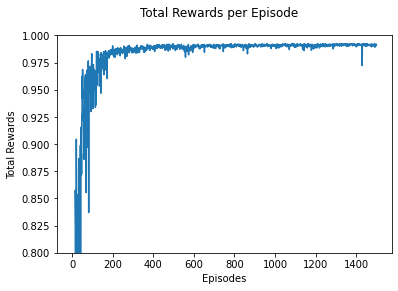

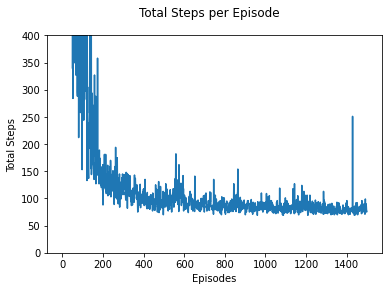

In [ ]:
# Convergence Graphs
plt.suptitle("Total Rewards per Episode")
plt.plot(rewards)
plt.ylabel('Total Rewards')
plt.xlabel("Episodes")
plt.ylim([0.8, 1])
plt.show()


plt.suptitle("Total Steps per Episode")
plt.plot(steps)
plt.ylabel('Total Steps')
plt.xlabel("Episodes")
plt.ylim([0, 400])
plt.show()

In [ ]:
# Stochastic Policy - Middle Episode
show_video_middle_of_training()

In [ ]:
# Stochastic Policy - Final Episode
show_video()

In [ ]:
# Convergence if we had a determenistic policy
EPOCHS = 2000
ALPHA = 0.6                   # learning rate
GAMMA = 0.975                 # discount rate
min_epsilon = 0.00            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

rewards, steps = train(EPOCHS, ALPHA, GAMMA, min_epsilon, decay_rate, True, False)

episode: 100, total_rewards: 0.9683, total_current_steps: 286, moving_average_steps: 2229.72
episode: 200, total_rewards: 0.9846, total_current_steps: 140, moving_average_steps: 240.18
episode: 300, total_rewards: 0.9919, total_current_steps: 74, moving_average_steps: 104.72
episode: 400, total_rewards: 0.9917, total_current_steps: 76, moving_average_steps: 82.91
episode: 500, total_rewards: 0.9923, total_current_steps: 70, moving_average_steps: 74.99
episode: 600, total_rewards: 0.9922, total_current_steps: 71, moving_average_steps: 71.38
episode: 700, total_rewards: 0.9928, total_current_steps: 66, moving_average_steps: 69.02
episode: 800, total_rewards: 0.9928, total_current_steps: 66, moving_average_steps: 67.97
episode: 900, total_rewards: 0.9927, total_current_steps: 67, moving_average_steps: 67.15
episode: 1000, total_rewards: 0.9928, total_current_steps: 66, moving_average_steps: 66.6
episode: 1100, total_rewards: 0.9928, total_current_steps: 66, moving_average_steps: 66.64
epi

In [ ]:
# Determenistic Policy - Best Policy in 66 steps
show_video()